In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    %pip install unsloth
else:
    # Colab installation
    %pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    %pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    %pip install --no-deps unsloth

# Install latest transformers for Gemma 3N
%pip install --no-deps transformers==4.53.1
%pip install --no-deps --upgrade timm

# Additional packages for evaluation
%pip install scikit-learn matplotlib seaborn tqdm


In [2]:
!pip show transformers

Name: transformers
Version: 4.53.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: kaggle-environments, peft, sentence-transformers, trl, unsloth, unsloth_zoo


In [3]:
!pip show timm

Name: timm
Version: 1.0.16
Summary: PyTorch Image Models
Home-page: https://github.com/huggingface/pytorch-image-models
Author: 
Author-email: Ross Wightman <ross@huggingface.co>
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: huggingface_hub, pyyaml, safetensors, torch, torchvision
Required-by: 


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# Verify D-Fire dataset structure
import os
DATASET_PATH = "/kaggle/input/d-fire"

print("Checking D-Fire dataset structure...")
if os.path.exists(DATASET_PATH):
    print(f"✅ Found D-Fire folder at: {DATASET_PATH}")

    for split in ["train", "test"]:
        split_path = os.path.join(DATASET_PATH, split)
        if os.path.exists(split_path):
            images_path = os.path.join(split_path, "images")
            labels_path = os.path.join(split_path, "labels")
            if os.path.exists(images_path) and os.path.exists(labels_path):
                print(f"✅ {split}: {len(os.listdir(images_path))} images, {len(os.listdir(labels_path))} labels")
            else:
                print(f"❌ Missing {split}/images or {split}/labels")
        else:
            print(f"❌ {split} folder not found")
else:
    print(f"❌ Dataset not found at: {DATASET_PATH}")


Checking D-Fire dataset structure...
✅ Found D-Fire folder at: /kaggle/input/d-fire
✅ train: 17221 images, 17221 labels
✅ test: 4306 images, 4306 labels


In [5]:
from unsloth import FastModel
import torch

# Load Gemma 3N model for inference
model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3n-E4B-it",
    dtype = None,  # Auto detection
    max_seq_length = 1024,
    load_in_4bit = True,
    # token = "hf_...",  # Add if using gated models
)

print("✅ Model loaded successfully!")
print(f"Model: {model.config.name_or_path}")
print(f"Device: {next(model.parameters()).device}")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-07-10 07:05:53.461902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752131153.638202      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752131153.698574      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.1: Fast Gemma3N patching. Transformers: 4.53.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

✅ Model loaded successfully!
Model: unsloth/gemma-3n-e4b-it-unsloth-bnb-4bit
Device: cuda:0


In [6]:
# Evaluation Configuration (similar to main.py)
DETECTION_PROMPTS = {
    "simple": "Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'.",
    "detailed": "Analyze this image carefully for fire or smoke detection. Look for flames, smoke clouds, or signs of burning. Respond with exactly one word: 'fire' if you see flames, 'smoke' if you see smoke without flames, 'both' if you see both fire and smoke, or 'none' if neither is present.",
    "context": "You are a fire detection system. Your task is to identify fire and smoke in images. Examine this image and classify what you see. Answer with only: 'fire', 'smoke', 'both', or 'none'."
}

# Category mappings
CATEGORY_LABELS = {
    "fire": "fire",
    "smoke": "smoke",
    "both": "both",
    "none": "none"
}

# Inference settings (recommended for Gemma 3N)
INFERENCE_SETTINGS = {
    "temperature": 1.0,
    "top_p": 0.95,
    "top_k": 64,
    "max_new_tokens": 16
}

# Setup session paths and logging (similar to main.py)
import logging
from datetime import datetime
from pathlib import Path

# Create session name
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
models_str = "gemma-3n-E4B-it"
prompts_str = "_".join(list(DETECTION_PROMPTS.keys())[:2])  # Use first 2 prompt types for name
session_name = f"{timestamp}_{models_str}_{prompts_str}_inference"

# Create directory structure
results_base = Path("results")
session_path = results_base / session_name
evals_path = session_path / "evals"
plots_path = session_path / "plots"
logs_path = Path("logs") / f"logs_{session_name}"

# Create directories
session_path.mkdir(parents=True, exist_ok=True)
evals_path.mkdir(parents=True, exist_ok=True)
plots_path.mkdir(parents=True, exist_ok=True)
logs_path.mkdir(parents=True, exist_ok=True)

# Setup logging
log_file = logs_path / "evaluation.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()  # Also log to console
    ]
)

logger = logging.getLogger("GemmaEvaluationNotebook")

print("✅ Configuration loaded:")
print(f"Prompt types: {list(DETECTION_PROMPTS.keys())}")
print(f"Category labels: {list(CATEGORY_LABELS.keys())}")
print(f"📁 Session folder: {session_path}")
print(f"📝 Logs will be saved to: {log_file}")

logger.info("=" * 80)
logger.info("GEMMA 3N D-FIRE INFERENCE SESSION STARTED")
logger.info("=" * 80)
logger.info(f"Session folder: {session_path}")
logger.info(f"Inference settings: {INFERENCE_SETTINGS}")
logger.info(f"Available prompts: {list(DETECTION_PROMPTS.keys())}")


✅ Configuration loaded:
Prompt types: ['simple', 'detailed', 'context']
Category labels: ['fire', 'smoke', 'both', 'none']
📁 Session folder: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference
📝 Logs will be saved to: logs/logs_2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/evaluation.log


In [7]:
import os
import random
from pathlib import Path
from PIL import Image
import json

class DFireEvaluationDataset:
    """D-Fire dataset loader for evaluation (similar to main.py's approach)."""

    def __init__(self, dataset_path: str):
        self.dataset_path = Path(dataset_path)
        self.train_path = self.dataset_path / "train"
        self.test_path = self.dataset_path / "test"

    def _load_yolo_labels(self, labels_dir: Path) -> dict:
        """Load YOLO format labels."""
        labels = {}
        for label_file in labels_dir.glob("*.txt"):
            image_name = label_file.stem
            annotations = []

            if label_file.stat().st_size > 0:
                with open(label_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_id = int(parts[0])
                            annotations.append({
                                'class_id': class_id,
                                'class_name': 'smoke' if class_id == 0 else 'fire'
                            })
            labels[image_name] = annotations
        return labels

    def _categorize_images(self, labels: dict) -> dict:
        """Categorize images based on annotations."""
        categories = {'fire': [], 'smoke': [], 'both': [], 'none': []}

        for image_name, annotations in labels.items():
            if not annotations:
                categories['none'].append(image_name)
            else:
                has_fire = any(ann['class_name'] == 'fire' for ann in annotations)
                has_smoke = any(ann['class_name'] == 'smoke' for ann in annotations)

                if has_fire and has_smoke:
                    categories['both'].append(image_name)
                elif has_fire:
                    categories['fire'].append(image_name)
                elif has_smoke:
                    categories['smoke'].append(image_name)
                else:
                    categories['none'].append(image_name)

        return categories

    def get_sample_images(self, split: str = "test", max_per_category: int = 50, seed: int = 42) -> list:
        """Get sample images for evaluation."""
        random.seed(seed)

        split_path = self.test_path if split == "test" else self.train_path
        images_dir = split_path / "images"
        labels_dir = split_path / "labels"

        if not images_dir.exists() or not labels_dir.exists():
            raise FileNotFoundError(f"Images or labels directory not found for {split} split")

        # Load labels and categorize
        labels = self._load_yolo_labels(labels_dir)
        categories = self._categorize_images(labels)

        # Sample images from each category
        sample_images = []
        for category, image_names in categories.items():
            if max_per_category and len(image_names) > max_per_category:
                selected_images = random.sample(image_names, max_per_category)
            else:
                selected_images = image_names

            for image_name in selected_images:
                image_path = images_dir / f"{image_name}.jpg"
                if image_path.exists():
                    sample_images.append({
                        'image_name': f"{image_name}.jpg",
                        'image_path': str(image_path),
                        'category': category,
                        'label': category,
                        'split': split
                    })

        return sample_images

    def get_dataset_stats(self, split: str = "test") -> dict:
        """Get dataset statistics."""
        split_path = self.test_path if split == "test" else self.train_path
        images_dir = split_path / "images"
        labels_dir = split_path / "labels"

        if not images_dir.exists() or not labels_dir.exists():
            return {'total_images': 0, 'categories': {}, 'annotations': {'total': 0, 'fire': 0, 'smoke': 0}}

        labels = self._load_yolo_labels(labels_dir)
        categories = self._categorize_images(labels)

        # Count annotations
        total_annotations = 0
        fire_annotations = 0
        smoke_annotations = 0

        for annotations in labels.values():
            total_annotations += len(annotations)
            fire_annotations += sum(1 for ann in annotations if ann['class_name'] == 'fire')
            smoke_annotations += sum(1 for ann in annotations if ann['class_name'] == 'smoke')

        total_images = sum(len(images) for images in categories.values())

        return {
            'total_images': total_images,
            'categories': {cat: len(images) for cat, images in categories.items()},
            'annotations': {
                'total': total_annotations,
                'fire': fire_annotations,
                'smoke': smoke_annotations
            }
        }

# Initialize dataset
dataset = DFireEvaluationDataset(DATASET_PATH)
print("✅ Dataset loader initialized")


✅ Dataset loader initialized


In [8]:
# Display dataset statistics
def display_dataset_stats(stats, split_name):
    print(f"\n📊 {split_name.upper()} Split Statistics:")
    print(f"Total Images: {stats['total_images']}")
    print("\nCategories:")
    for category, count in stats['categories'].items():
        percentage = (count / stats['total_images'] * 100) if stats['total_images'] > 0 else 0
        print(f"  {category.title()}: {count} ({percentage:.1f}%)")

    print("\nAnnotations:")
    ann_stats = stats['annotations']
    print(f"  Fire: {ann_stats['fire']}")
    print(f"  Smoke: {ann_stats['smoke']}")
    print(f"  Total: {ann_stats['total']}")

# Get and display statistics for both splits
# test_stats = dataset.get_dataset_stats("test")
# train_stats = dataset.get_dataset_stats("train")

# display_dataset_stats(test_stats, "test")
# display_dataset_stats(train_stats, "train")


In [9]:
from unsloth.chat_templates import get_chat_template
from transformers import TextStreamer
import time

# Setup chat template
# processor = get_chat_template(tokenizer, chat_template="gemma-3")

def evaluate_single_image(image_path: str, prompt: str, verbose: bool = False) -> dict:
    """Evaluate a single image with the model."""
    try:
        start_time = time.time()

        # Prepare messages
        messages = [{
            "role": "user",
            "content": [
                {"type": "image", "image": image_path},
                {"type": "text", "text": prompt}
            ]
        }]

        # Apply chat template and generate - Use the same approach as do_gemma_3n_inference
        # This fixes the "Number of images does not match number of special image tokens" error
        # by ensuring the chat template properly handles image tokens
        outputs = model.generate(
            **tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=True,
                tokenize=True,
                return_dict=True,
                return_tensors="pt",
            ).to("cuda"),
            max_new_tokens=INFERENCE_SETTINGS["max_new_tokens"],
            temperature=INFERENCE_SETTINGS["temperature"],
            top_p=INFERENCE_SETTINGS["top_p"],
            top_k=INFERENCE_SETTINGS["top_k"],
            streamer = TextStreamer(tokenizer, skip_prompt = True),
        )

        # Decode response
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract model response - split by lines and find the last meaningful line
        lines = response.strip().split('\n')

        # Find the last line that contains just the model response
        answer = ""
        for i in range(len(lines) - 1, -1, -1):  # Go backwards through lines
            line = lines[i].strip()
            if line and line.lower() in ["fire", "smoke", "both", "none"]:
                answer = line.lower()
                break

        # If no direct match found, try to find after "model" marker
        if not answer:
            # Look for "model" marker and get the next non-empty line
            for i, line in enumerate(lines):
                if line.strip() == "model" and i + 1 < len(lines):
                    next_line = lines[i + 1].strip().lower()
                    if next_line in ["fire", "smoke", "both", "none"]:
                        answer = next_line
                        break

        # Final fallback - if still no answer, default to "none"
        if not answer:
            answer = "none"

        predicted_label = answer

        processing_time = time.time() - start_time

        if verbose:
            print(f"Full response: {response}")
            print(f"Extracted answer: '{answer}'")
            print(f"Predicted: {predicted_label}")

        return {
            "predicted_label": predicted_label,
            "raw_response": answer,
            "processing_time": processing_time,
            "error": None
        }

    except Exception as e:
        return {
            "predicted_label": "none",
            "raw_response": "",
            "processing_time": 0,
            "error": str(e)
        }

def evaluate_images_batch(sample_images: list, prompt_type: str, verbose: bool = False) -> list:
    """Evaluate a batch of images."""
    results = []
    prompt = DETECTION_PROMPTS[prompt_type]

    print(f"\n🔍 Evaluating {len(sample_images)} images with '{prompt_type}' prompt...")

    for i, sample in enumerate(sample_images):
        if verbose or (i + 1) % 10 == 0:
            print(f"Processing image {i+1}/{len(sample_images)}: {sample['image_name']}")

        # Evaluate image
        eval_result = evaluate_single_image(sample['image_path'], prompt, verbose=verbose)

        # Combine with sample info
        result = {
            **sample,
            **eval_result,
            "prompt_type": prompt_type,
            "prompt": prompt,
            "model": "gemma-3n-E4B-it"
        }

        results.append(result)

        if verbose:
            print(f"  Expected: {sample['label']} | Predicted: {eval_result['predicted_label']}")
            print(f"  Time: {eval_result['processing_time']:.2f}s")
            if eval_result['error']:
                print(f"  Error: {eval_result['error']}")

    return results

print("✅ Inference functions loaded")


✅ Inference functions loaded


In [10]:
# Configuration for sampling
MAX_IMAGES_PER_CATEGORY = 3000  # Adjust based on your needs
DATASET_SPLIT = "test"  # or "train"

# Sample images
print(f"📸 Sampling {MAX_IMAGES_PER_CATEGORY} images per category from {DATASET_SPLIT} split...")
logger.info(f"Sampling {MAX_IMAGES_PER_CATEGORY} images per category from {DATASET_SPLIT} split")

sample_images = dataset.get_sample_images(
    split=DATASET_SPLIT,
    max_per_category=MAX_IMAGES_PER_CATEGORY,
    seed=42
)

print(f"✅ Selected {len(sample_images)} images for evaluation")
logger.info(f"Selected {len(sample_images)} images for evaluation")

# Display sample distribution
from collections import Counter
category_counts = Counter(img['category'] for img in sample_images)
print("\nSample distribution:")
for category, count in category_counts.items():
    print(f"  {category.title()}: {count} images")
    logger.info(f"  {category.title()}: {count} images")

logger.info(f"Dataset split: {DATASET_SPLIT}")
logger.info(f"Max images per category: {MAX_IMAGES_PER_CATEGORY}")


📸 Sampling 3000 images per category from test split...
✅ Selected 4306 images for evaluation

Sample distribution:
  Fire: 220 images
  Smoke: 1186 images
  Both: 895 images
  None: 2005 images


In [11]:
# Run evaluation with different prompt types
all_results = []

# Select prompt types to evaluate
PROMPT_TYPES_TO_EVALUATE = ["simple", "detailed"]  # Add "context" if needed

logger.info("Starting evaluation process...")
logger.info(f"Prompt types to evaluate: {PROMPT_TYPES_TO_EVALUATE}")

for prompt_type in PROMPT_TYPES_TO_EVALUATE:
    print(f"\n{'='*60}")
    print(f"🚀 Starting evaluation with '{prompt_type}' prompt")
    print(f"{'='*60}")
    logger.info(f"Starting evaluation with {prompt_type} prompts")

    # Evaluate with current prompt type
    results = evaluate_images_batch(
        sample_images,
        prompt_type,
        verbose=True  # Set to True for detailed output
    )

    all_results.extend(results)

    # Quick summary for this prompt type
    correct = sum(1 for r in results if r['label'] == r['predicted_label'] and not r['error'])
    total = len(results)
    accuracy = correct / total if total > 0 else 0

    print(f"\n📊 {prompt_type.title()} Results:")
    print(f"  Accuracy: {accuracy:.3f} ({correct}/{total})")
    print(f"  Errors: {sum(1 for r in results if r['error'])}")

    logger.info(f"Completed evaluation with {prompt_type} prompts. Got {len(results)} results.")
    logger.info(f"{prompt_type} Accuracy: {accuracy:.3f} ({correct}/{total})")

print(f"\n✅ Evaluation complete! Total results: {len(all_results)}")
logger.info("Evaluation process completed")
logger.info(f"Total evaluation results: {len(all_results)}")



🚀 Starting evaluation with 'simple' prompt

🔍 Evaluating 4306 images with 'simple' prompt...
Processing image 1/4306: AoF07901.jpg
none<end_of_turn>
Full response: user




Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'.
model
none
Extracted answer: 'none'
Predicted: none
  Expected: fire | Predicted: none
  Time: 90.75s
Processing image 2/4306: AoF07858.jpg
fire<end_of_turn>
Full response: user




Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'.
model
fire
Extracted answer: 'fire'
Predicted: fire
  Expected: fire | Predicted: fire
  Time: 1.58s
Processing image 3/4306: AoF07849.jpg
fire<end_of_turn>
Full response: user




Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'.
model
fire
Extracted answer: 'fire'
Predicted: fire
  Expected: fire | Predicted: fire
  Time: 0.97s
Processing image 4/4306: WEB10911.jpg
fire<end_of_turn>
Full response: user



📊 Running performance analysis...

📈 Overall Performance
Total Evaluations: 8612
Successful Evaluations: 8612
Error Rate: 0.000
Accuracy: 0.760
F1-Score: 0.759
Average Processing Time: 0.91s

📊 Classification Report:
  Fire: P=0.739, R=0.791, F1=0.764
  Smoke: P=0.373, R=0.445, F1=0.406
  Both: P=0.837, R=0.869, F1=0.853
  None: P=0.723, R=0.613, F1=0.663


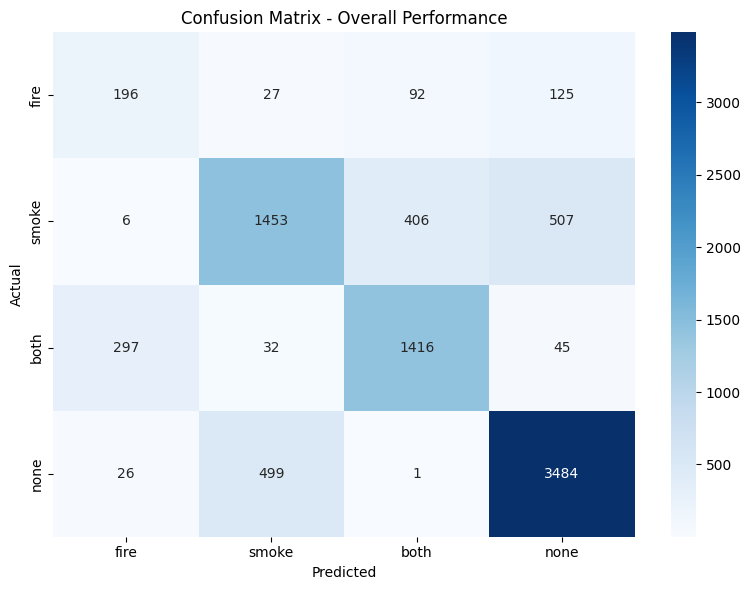


📈 Performance - Simple Prompt
Total Evaluations: 4306
Successful Evaluations: 4306
Error Rate: 0.000
Accuracy: 0.724
F1-Score: 0.730
Average Processing Time: 0.92s

📊 Classification Report:
  Fire: P=0.670, R=0.739, F1=0.703
  Smoke: P=0.351, R=0.573, F1=0.435
  Both: P=0.881, R=0.801, F1=0.839
  None: P=0.635, R=0.609, F1=0.622


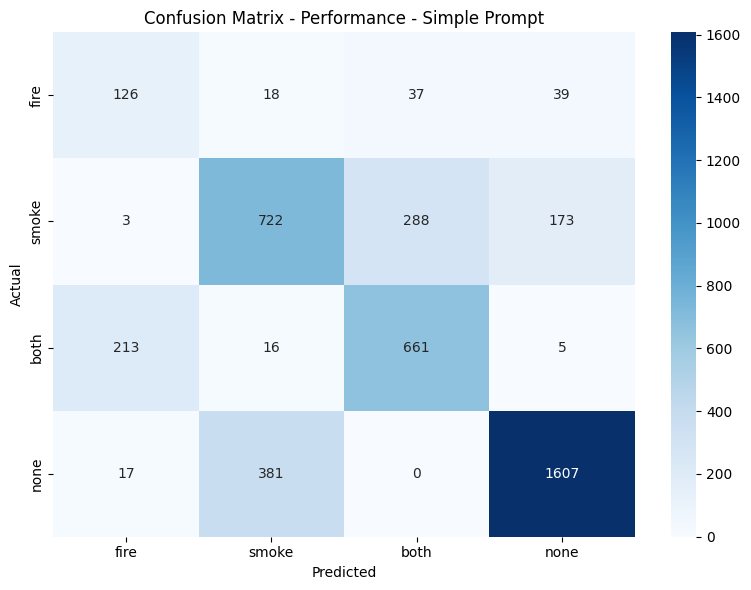


📈 Performance - Detailed Prompt
Total Evaluations: 4306
Successful Evaluations: 4306
Error Rate: 0.000
Accuracy: 0.797
F1-Score: 0.789
Average Processing Time: 0.91s

📊 Classification Report:
  Fire: P=0.813, R=0.844, F1=0.828
  Smoke: P=0.422, R=0.318, F1=0.363
  Both: P=0.803, R=0.936, F1=0.865
  None: P=0.836, R=0.616, F1=0.710


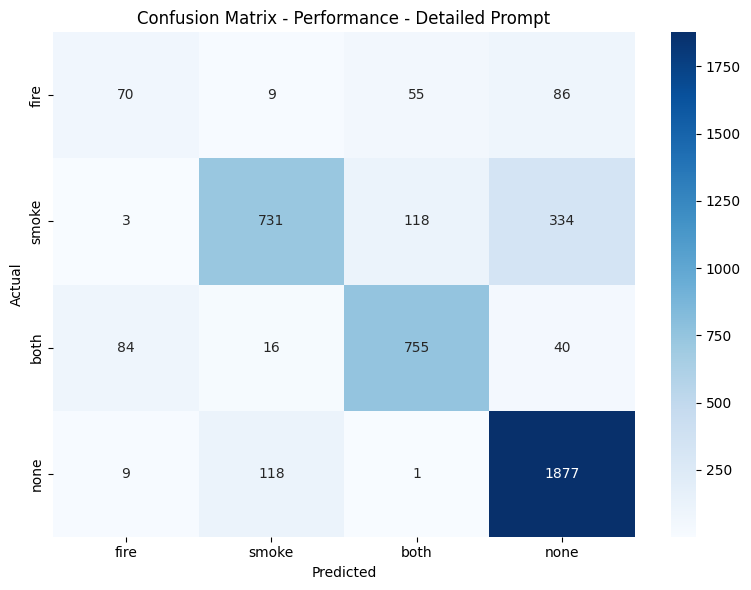

✅ Performance analysis complete!


In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(results: list) -> dict:
    """Analyze evaluation results."""
    # Filter successful results
    successful_results = [r for r in results if not r['error']]

    if not successful_results:
        print("❌ No successful results to analyze")
        return {}

    # Extract labels and predictions
    true_labels = [r['label'] for r in successful_results]
    predicted_labels = [r['predicted_label'] for r in successful_results]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Processing time stats
    processing_times = [r['processing_time'] for r in successful_results]
    avg_processing_time = np.mean(processing_times)

    # Classification report
    class_report = classification_report(
        true_labels, predicted_labels,
        target_names=['fire', 'smoke', 'both', 'none'],
        zero_division=0,
        output_dict=True
    )

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels,
                         labels=['fire', 'smoke', 'both', 'none'])

    analysis = {
        'total_evaluations': len(results),
        'successful_evaluations': len(successful_results),
        'error_rate': (len(results) - len(successful_results)) / len(results),
        'accuracy': accuracy,
        'f1_score': f1,
        'average_processing_time': avg_processing_time,
        'classification_report': class_report,
        'confusion_matrix': cm,
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

    return analysis

def display_analysis(analysis: dict, title: str = "Performance Analysis", plots_dir: str = None):
    """Display analysis results and save plots."""
    print(f"\n{'='*60}")
    print(f"📈 {title}")
    print(f"{'='*60}")

    print(f"Total Evaluations: {analysis['total_evaluations']}")
    print(f"Successful Evaluations: {analysis['successful_evaluations']}")
    print(f"Error Rate: {analysis['error_rate']:.3f}")
    print(f"Accuracy: {analysis['accuracy']:.3f}")
    print(f"F1-Score: {analysis['f1_score']:.3f}")
    print(f"Average Processing Time: {analysis['average_processing_time']:.2f}s")

    # Display classification report
    print("\n📊 Classification Report:")
    class_report = analysis['classification_report']

    for label in ['fire', 'smoke', 'both', 'none']:
        if label in class_report:
            metrics = class_report[label]
            print(f"  {label.title()}: P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(analysis['confusion_matrix'],
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['fire', 'smoke', 'both', 'none'],
                yticklabels=['fire', 'smoke', 'both', 'none'])
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()

    # Save plot if plots_dir is provided
    if plots_dir:
        plot_filename = title.lower().replace(' ', '_').replace('-', '_') + '_confusion_matrix.png'
        plot_path = Path(plots_dir) / plot_filename
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"📈 Plot saved to: {plot_path}")

    plt.show()

def generate_performance_plots(all_results: list, plots_dir: str):
    """Generate comprehensive performance plots and save them."""
    plots_dir = Path(plots_dir)
    plots_dir.mkdir(parents=True, exist_ok=True)

    # 1. Performance by prompt type
    if len(PROMPT_TYPES_TO_EVALUATE) > 1:
        prompt_metrics = {}
        for prompt_type in PROMPT_TYPES_TO_EVALUATE:
            prompt_results = [r for r in all_results if r['prompt_type'] == prompt_type]
            if prompt_results:
                prompt_analysis = analyze_results(prompt_results)
                prompt_metrics[prompt_type] = {
                    'accuracy': prompt_analysis['accuracy'],
                    'f1_score': prompt_analysis['f1_score'],
                    'processing_time': prompt_analysis['average_processing_time']
                }

        if prompt_metrics:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Accuracy comparison
            prompts = list(prompt_metrics.keys())
            accuracies = [prompt_metrics[p]['accuracy'] for p in prompts]
            axes[0].bar(prompts, accuracies, color='skyblue')
            axes[0].set_title('Accuracy by Prompt Type')
            axes[0].set_ylabel('Accuracy')
            axes[0].set_ylim(0, 1)
            for i, v in enumerate(accuracies):
                axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

            # F1-Score comparison
            f1_scores = [prompt_metrics[p]['f1_score'] for p in prompts]
            axes[1].bar(prompts, f1_scores, color='lightgreen')
            axes[1].set_title('F1-Score by Prompt Type')
            axes[1].set_ylabel('F1-Score')
            axes[1].set_ylim(0, 1)
            for i, v in enumerate(f1_scores):
                axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

            # Processing time comparison
            times = [prompt_metrics[p]['processing_time'] for p in prompts]
            axes[2].bar(prompts, times, color='lightcoral')
            axes[2].set_title('Processing Time by Prompt Type')
            axes[2].set_ylabel('Time (seconds)')
            for i, v in enumerate(times):
                axes[2].text(i, v + 0.1, f'{v:.2f}s', ha='center')

            plt.tight_layout()
            plot_path = plots_dir / "prompt_comparison.png"
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            print(f"📈 Prompt comparison plot saved to: {plot_path}")
            plt.show()

    # 2. Processing time distribution
    processing_times = [r['processing_time'] for r in all_results if not r['error']]
    if processing_times:
        plt.figure(figsize=(10, 6))
        plt.hist(processing_times, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Processing Time Distribution')
        plt.xlabel('Processing Time (seconds)')
        plt.ylabel('Frequency')
        plt.axvline(np.mean(processing_times), color='red', linestyle='--',
                   label=f'Mean: {np.mean(processing_times):.2f}s')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plot_path = plots_dir / "processing_time_distribution.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"📈 Processing time distribution saved to: {plot_path}")
        plt.show()

# Note: plots_dir will be set when we create the directory structure
# For now, just run the analysis
print("📊 Running performance analysis...")

# Analyze overall results
overall_analysis = analyze_results(all_results)
display_analysis(overall_analysis, "Overall Performance")

# Analyze by prompt type
for prompt_type in PROMPT_TYPES_TO_EVALUATE:
    prompt_results = [r for r in all_results if r['prompt_type'] == prompt_type]
    prompt_analysis = analyze_results(prompt_results)
    display_analysis(prompt_analysis, f"Performance - {prompt_type.title()} Prompt")

print("✅ Performance analysis complete!")


💾 Saving results to session folder: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference
💾 Raw results saved to: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/evals/raw_results.json
📊 Analysis report saved to: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/evals/evaluation_report.json
📋 Human-readable summary saved to: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/evals/evaluation_report.txt

📈 Generating and saving plots...
📈 Prompt comparison plot saved to: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/plots/prompt_comparison.png


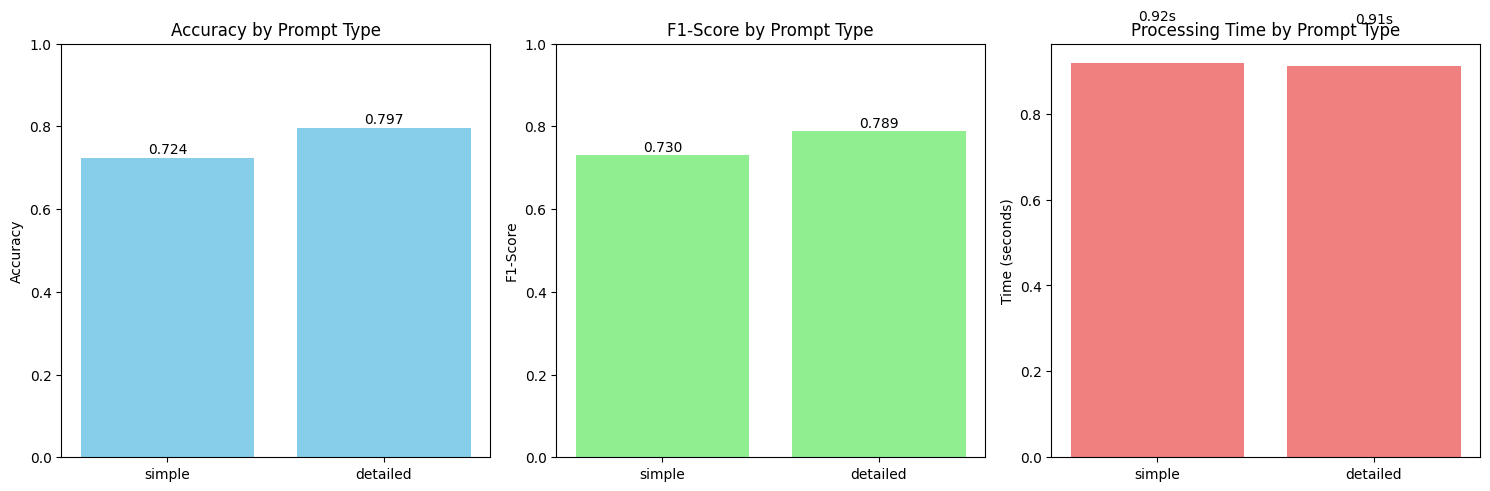

📈 Processing time distribution saved to: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/plots/processing_time_distribution.png


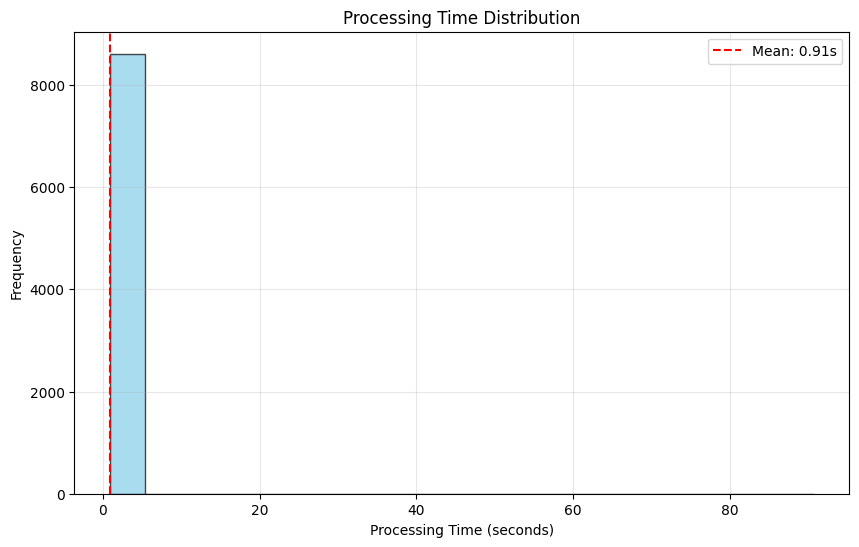

📈 Simple confusion matrix saved to: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/plots/simple_confusion_matrix.png
📈 Detailed confusion matrix saved to: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/plots/detailed_confusion_matrix.png
📈 Overall confusion matrix saved to: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/plots/overall_confusion_matrix.png

🎯 Key Results:
  Overall Accuracy: 0.760
  Overall F1-Score: 0.759
  Average Processing Time: 0.91s
  Total Images Evaluated: 8612
  Error Rate: 0.000

📁 All results saved to session folder: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference
   📊 Evaluations: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/evals
   📈 Plots: results/2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference/plots
   📝 Logs: logs/logs_2025-07-10_07-07-37_gemma-3n-E4B-it_simple_detailed_inference

🎉 Evaluation pipeline completed successfully!


In [13]:
# Save results to files (using pre-configured paths)
import json

print(f"💾 Saving results to session folder: {session_path}")
logger.info("Starting results saving process...")
logger.info(f"Saving to session: {session_path}")

# Save raw results to evals folder
results_file = evals_path / "raw_results.json"
with open(results_file, 'w') as f:
    json.dump(all_results, f, indent=2, default=str)

print(f"💾 Raw results saved to: {results_file}")
logger.info(f"Raw results saved to: {results_file}")

# Save analysis summary to evals folder
analysis_file = evals_path / "evaluation_report.json"
analysis_summary = {
    'evaluation_summary': {
        'total_evaluations': len(all_results),
        'successful_evaluations': overall_analysis['successful_evaluations'],
        'error_rate': overall_analysis['error_rate'],
        'models_evaluated': ['gemma-3n-E4B-it'],
        'prompt_types_used': PROMPT_TYPES_TO_EVALUATE,
    },
    # 'dataset_statistics': {
    #     'test': test_stats,
    #     'train': train_stats
    # },
    'performance_metrics': {
        'total_evaluations': len(all_results),
        'successful_evaluations': overall_analysis['successful_evaluations'],
        'error_rate': overall_analysis['error_rate'],
        'average_processing_time': overall_analysis['average_processing_time'],
        'classification': {
            'accuracy': overall_analysis['accuracy'],
            'f1_score': overall_analysis['f1_score'],
            'precision': overall_analysis['classification_report'].get('weighted avg', {}).get('precision', 0),
            'recall': overall_analysis['classification_report'].get('weighted avg', {}).get('recall', 0)
        }
    },
    'configuration': {
        'model': 'gemma-3n-E4B-it',
        'dataset_split': DATASET_SPLIT,
        'max_images_per_category': MAX_IMAGES_PER_CATEGORY,
        'prompt_types': PROMPT_TYPES_TO_EVALUATE,
        'inference_settings': INFERENCE_SETTINGS
    },
    'timestamp': timestamp
}

with open(analysis_file, 'w') as f:
    json.dump(analysis_summary, f, indent=2, default=str)

print(f"📊 Analysis report saved to: {analysis_file}")
logger.info(f"Analysis report saved to: {analysis_file}")

# Save human-readable summary
summary_file = evals_path / "evaluation_report.txt"
with open(summary_file, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("GEMMA 3N FIRE/SMOKE DETECTION EVALUATION REPORT\n")
    f.write("=" * 80 + "\n\n")

    # Summary
    f.write("EVALUATION SUMMARY\n")
    f.write("-" * 20 + "\n")
    f.write(f"Total Evaluations: {len(all_results)}\n")
    f.write(f"Successful Evaluations: {overall_analysis['successful_evaluations']}\n")
    f.write(f"Error Rate: {overall_analysis['error_rate']:.2%}\n")
    f.write(f"Model Evaluated: gemma-3n-E4B-it\n")
    f.write(f"Prompt Types: {', '.join(PROMPT_TYPES_TO_EVALUATE)}\n\n")

    # Dataset Statistics
    f.write("DATASET STATISTICS\n")
    f.write("-" * 20 + "\n")
    # stats = test_stats if DATASET_SPLIT == 'test' else train_stats
    # f.write(f"Total Images: {stats.get('total_images', 'N/A')}\n")
    # if 'categories' in stats:
    #     for category, count in stats['categories'].items():
    #         f.write(f"  {category.title()}: {count}\n")
    f.write("\n")

    # Performance Metrics
    f.write("OVERALL PERFORMANCE\n")
    f.write("-" * 20 + "\n")
    f.write(f"Accuracy: {overall_analysis['accuracy']:.3f}\n")
    f.write(f"F1-Score: {overall_analysis['f1_score']:.3f}\n")
    f.write(f"Average Processing Time: {overall_analysis['average_processing_time']:.2f}s\n")

    # Per-prompt performance
    f.write(f"\nPer-Prompt Performance:\n")
    f.write("=" * 30 + "\n")
    for prompt_type in PROMPT_TYPES_TO_EVALUATE:
        prompt_results = [r for r in all_results if r['prompt_type'] == prompt_type]
        if prompt_results:
            prompt_analysis = analyze_results(prompt_results)
            f.write(f"\n{prompt_type.title()} Prompt:\n")
            f.write(f"  Accuracy: {prompt_analysis['accuracy']:.3f}\n")
            f.write(f"  F1-Score: {prompt_analysis['f1_score']:.3f}\n")
            f.write(f"  Evaluations: {prompt_analysis['successful_evaluations']}\n")

    f.write("\n" + "=" * 80 + "\n")
    f.write("Report generated by Gemma 3N D-Fire Inference Notebook\n")
    f.write("=" * 80 + "\n")

print(f"📋 Human-readable summary saved to: {summary_file}")
logger.info(f"Human-readable summary saved to: {summary_file}")

# Generate and save plots to plots folder
print("\n📈 Generating and saving plots...")
generate_performance_plots(all_results, plots_path)

# Save confusion matrices with plots_dir
for prompt_type in PROMPT_TYPES_TO_EVALUATE:
    prompt_results = [r for r in all_results if r['prompt_type'] == prompt_type]
    if prompt_results:
        prompt_analysis = analyze_results(prompt_results)
        # Save confusion matrix for this prompt type
        plt.figure(figsize=(8, 6))
        sns.heatmap(prompt_analysis['confusion_matrix'],
                    annot=True, fmt='d', cmap='Blues',
                    xticklabels=['fire', 'smoke', 'both', 'none'],
                    yticklabels=['fire', 'smoke', 'both', 'none'])
        plt.title(f'Confusion Matrix - {prompt_type.title()} Prompt')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()

        plot_path = plots_path / f"{prompt_type}_confusion_matrix.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"📈 {prompt_type.title()} confusion matrix saved to: {plot_path}")
        plt.close()  # Close to avoid displaying in notebook

# Save overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_analysis['confusion_matrix'],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['fire', 'smoke', 'both', 'none'],
            yticklabels=['fire', 'smoke', 'both', 'none'])
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()

overall_plot_path = plots_path / "overall_confusion_matrix.png"
plt.savefig(overall_plot_path, dpi=300, bbox_inches='tight')
print(f"📈 Overall confusion matrix saved to: {overall_plot_path}")
plt.close()

# Display key metrics
print(f"\n🎯 Key Results:")
print(f"  Overall Accuracy: {overall_analysis['accuracy']:.3f}")
print(f"  Overall F1-Score: {overall_analysis['f1_score']:.3f}")
print(f"  Average Processing Time: {overall_analysis['average_processing_time']:.2f}s")
print(f"  Total Images Evaluated: {overall_analysis['successful_evaluations']}")
print(f"  Error Rate: {overall_analysis['error_rate']:.3f}")

print(f"\n📁 All results saved to session folder: {session_path}")
print(f"   📊 Evaluations: {evals_path}")
print(f"   📈 Plots: {plots_path}")
print(f"   📝 Logs: {logs_path}")

logger.info("=" * 80)
logger.info("EVALUATION SESSION COMPLETED SUCCESSFULLY")
logger.info("=" * 80)
logger.info(f"Overall accuracy: {overall_analysis['accuracy']:.3f}")
logger.info(f"Overall F1-score: {overall_analysis['f1_score']:.3f}")
logger.info(f"Results saved to: {session_path}")
logger.info(f"Raw results: {results_file}")
logger.info(f"Analysis report: {analysis_file}")
logger.info(f"Plots generated: {plots_path}")

print("\n🎉 Evaluation pipeline completed successfully!")


In [14]:
# Test individual images with detailed output
print("\n🔍 Testing Individual Images:")

# Select a few samples from each category
test_samples = []
for category in ['fire', 'smoke', 'both', 'none']:
    category_samples = [img for img in sample_images if img['category'] == category]
    if category_samples:
        test_samples.append(category_samples[0])  # Take first sample from each category

# Test with simple prompt
prompt = DETECTION_PROMPTS['simple']

for i, sample in enumerate(test_samples):
    print(f"\n--- Test {i+1} ---")
    print(f"Image: {sample['image_name']}")
    print(f"Category: {sample['category']}")
    print(f"Expected: {sample['label']}")

    # Evaluate image
    result = evaluate_single_image(sample['image_path'], prompt, verbose=True)

    # Show result
    print(f"Predicted: {result['predicted_label']}")
    print(f"Correct: {'✅' if result['predicted_label'] == sample['label'] else '❌'}")
    print(f"Processing Time: {result['processing_time']:.2f}s")

    if result['error']:
        print(f"Error: {result['error']}")



🔍 Testing Individual Images:

--- Test 1 ---
Image: AoF07901.jpg
Category: fire
Expected: fire
none<end_of_turn>
Full response: user




Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'.
model
none
Extracted answer: 'none'
Predicted: none
Predicted: none
Correct: ❌
Processing Time: 0.91s

--- Test 2 ---
Image: AoF08003.jpg
Category: smoke
Expected: smoke
none<end_of_turn>
Full response: user




Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'.
model
none
Extracted answer: 'none'
Predicted: none
Predicted: none
Correct: ❌
Processing Time: 0.89s

--- Test 3 ---
Image: WEB10642.jpg
Category: both
Expected: both
both<end_of_turn>
Full response: user




Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'.
model
both
Extracted answer: 'both'
Predicted: both
Predicted: both
Correct: ✅
Processing Time: 0.86s

--- Test 4 ---
Image: WEB09687.jpg
Category: none
Ex